# Movie Recommender System (user-to-user collaborative filtering)
## Movie & User Exploratory Data Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
import re

import utils 
import user_based_recommender 
import naive_recommender 
import similarity 

In [ ]:
data_source = utils.load_dataset_from_source("../LAB_DATABASE/ml_latest_small")
print(data_source.keys())

#load each dataframe from the data source
ratings = data_source["ratings.csv"]
tags = data_source["tags.csv"]
movies = data_source["movies.csv"]
links = data_source["links.csv"]

### Movies Analysis
Movies dataframe needs to be preprocessed, because generes are stored as string concatenated using "|" which can be removed using pandas Series.str.get_dummies(). Also release_year is inside the title and that's a bit sus indeed

In [ ]:
#MOVIES PREPROCESSING
#Extract year using regex
pattern = re.compile(r'(?P<title>.+?) \((?P<year>\d{4})\)')
movies["year"] = movies["title"].str.extract(pattern)["year"]
movies["title"] = movies["title"].str.extract(pattern)["title"]
movies = movies.join(movies['genres'].str.get_dummies().astype(bool))
movies.drop(columns=["genres"], inplace=True)
movies


In [ ]:
plt.figure(figsize=(12,6))
plt.bar(sorted(np.array(movies["year"].dropna().unique(), dtype=int)) ,movies.groupby("year").size(), color="red") #groupby?
plt.xlabel("Release year")
plt.ylabel("Number of movies")
plt.title("Number of movies grouped by release year")
plt.xticks(np.arange(1900, 2020, 5))
plt.show()

In [ ]:
not_genre_columns = ["movieId", "title", "year"]
genres = movies.drop(columns=not_genre_columns, inplace=False)
genres_df = pd.DataFrame({"genre": genres.columns, "sum": genres.sum()})
genres_df = genres_df.sort_values(by="sum")

plt.figure(figsize=(12,6))
plt.barh(list(genres_df["genre"]) ,genres_df["sum"], color="purple") #groupby?
plt.xlabel("Movie Genres")
plt.ylabel("Number of movies")
plt.xticks(ticks=np.arange(0, 5000, 250), rotation=90)
plt.title("Number of movies that belong to each Genre (Movies can be in multiple genres)")
plt.show()

In [ ]:
movies.groupby(["year"])["title"].count().nlargest(5).index.values

Conclusions: Based on this subset,he number of movies produced, has been growing almost exponentially from the seventies (Before this exponential trend it was sublinear) but it has stopped (the given data may be biased). Also the 5 biggest genres by far are Drama, Comedy, Thriller, Action & Romance and looking at the plot it looks like kind of a zipfian distribution

### Ratings Analysis
Honestly we don't care about the timestamps, just the ratings, users and movies. Also Links dataframe isn't necessary at all (useful though)

In [ ]:
ratings

In [ ]:
ratings.groupby("rating").size()

subratings = pd.DataFrame({"rating": sorted(ratings["rating"].unique()), "num_ratings": ratings.groupby("rating").size()})

plt.bar(subratings["rating"], subratings["num_ratings"], width=0.4, color="black")
plt.xticks(ticks=np.arange(0, 5.1, 0.5))
plt.title("Number of ratings for each star category")
plt.xlabel("Number of stars (from 0.5 to 5)")
plt.ylabel("Number of total ratings")
plt.show()

weighted_sum = (subratings['rating'] * subratings['num_ratings']).sum()
total_ratings = subratings['num_ratings'].sum()
average_rating = weighted_sum / total_ratings

print(f"Number of unique users who rated: {ratings['userId'].nunique()}")
print(f"The average rating is {average_rating}")
print(f"The number of different movies that have been rated are {ratings['movieId'].nunique()}")
print(f"The number of ratings is {len(ratings)}")

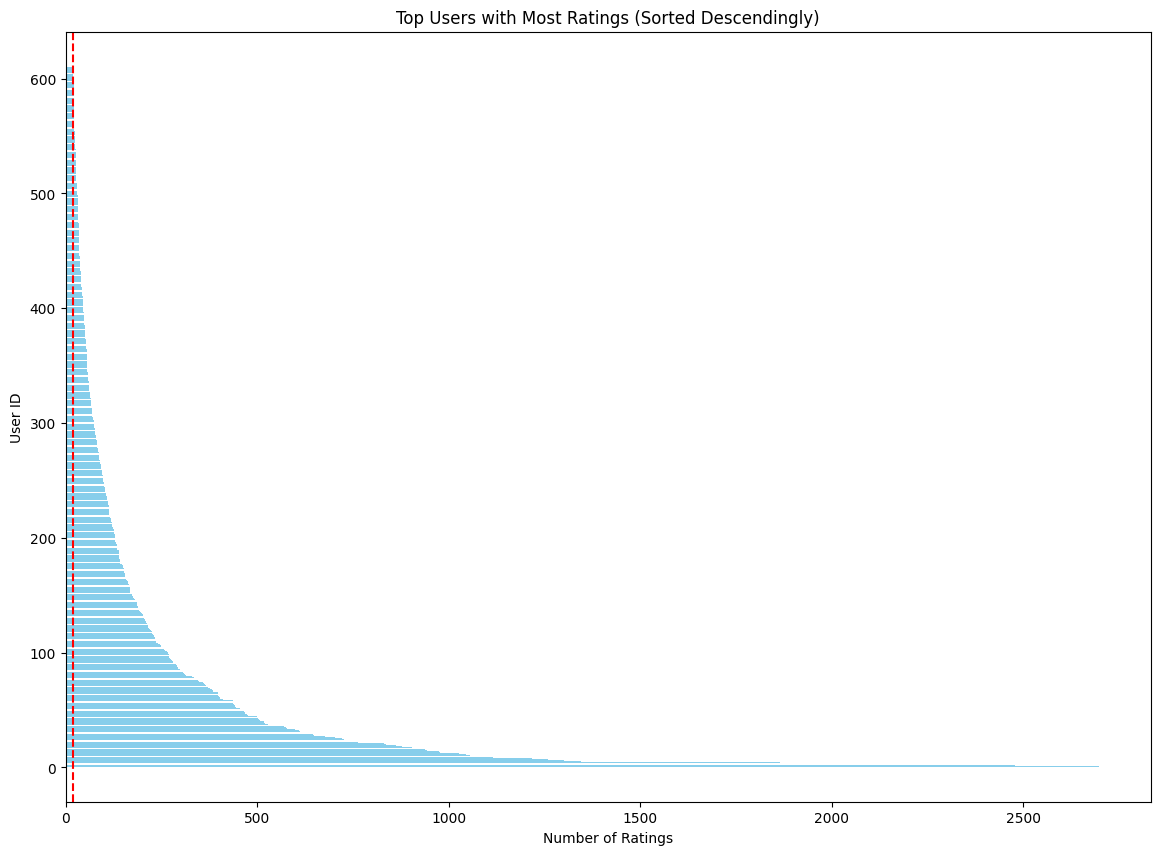

In [44]:
# Group by userId and count the number of ratings
user_ratings = ratings.groupby('userId').size().reset_index(name='num_ratings')

# Sort the DataFrame by the number of ratings in descending order
user_ratings = user_ratings.sort_values(by='num_ratings', ascending=False)

# Create a sequential range of integers as a replacement for user IDs
user_ids = range(1, len(user_ratings) + 1)

# Create horizontal bar plot
plt.figure(figsize=(14, 10))
plt.barh(user_ids, user_ratings['num_ratings'], color='skyblue')

plt.axvline(x=user_ratings['num_ratings'].min(), color='red', linestyle='--', label='Min Value')
plt.title('Top Users with Most Ratings (Sorted Descendingly)')
plt.xlabel('Number of Ratings')
plt.ylabel('User ID')
plt.show()


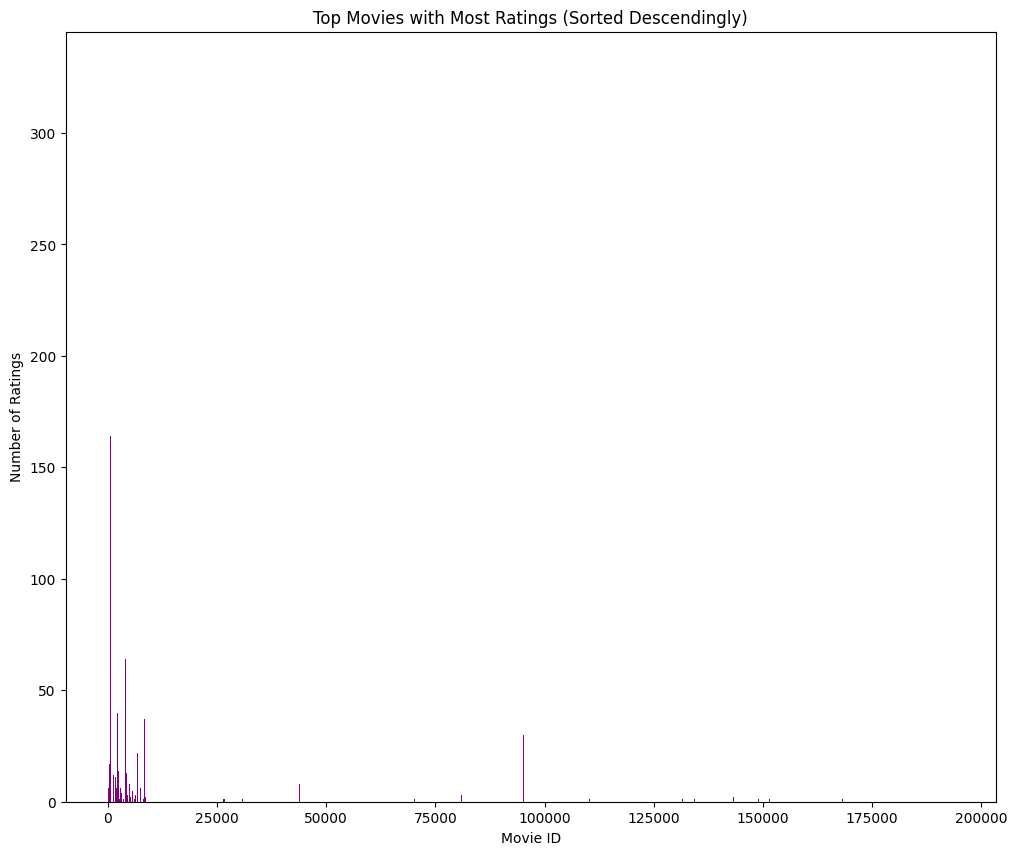

In [60]:
movie_ratings = ratings.groupby("movieId").size()
movie_ratings = movie_ratings.sort_values(ascending=False)


plt.figure(figsize=(12,10))
plt.bar(movie_ratings.index, movie_ratings.values, color="purple")
plt.title('Top Movies with Most Ratings (Sorted Descendingly)')
plt.ylabel('Number of Ratings')
plt.xlabel('Movie ID')
plt.show()

In [46]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Conclusions: This dataset follows a rating criteria of half stars (10 possible values, full star , half star or combination of both). The reviews doesn't follow a normal didstribution at all, but it is true that the average is centered in 3.5, it's a left-skewed distribution. Also the ratings are distributed following a zipfian distribution (a few users have the vast majority of reviews, the second has a lot less than the first, the third lot less than the second and so on and so on). Considering the distribution of ratings on each movie, we see that there's a lot of movies with a small or not a single rating and there's a few movies that have the vast amount of ratings